## Load packages

In [1]:
from pathlib import Path

import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from lib.shared.file_utils import get_filename
from lib.aggregate.filter import load_parquet_subset
from lib.aggregate.cell_classification import CellClassifier
from lib.aggregate.montage_utils import create_cell_montage, add_filenames

## Load test data

In [2]:
CONFIG_FILE_PATH = "config/config.yml"
TEST_PLATE = 1
TEST_WELL = "A1"

In [3]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# Load subset of data
# Takes ~1 minute
merge_final_fp = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "merge_final", "parquet")
)
cell_data = load_parquet_subset(merge_final_fp, n_rows=50000)
display(cell_data)

print("First 20 columns; use to set parameters below.")
for index, col in enumerate(cell_data.columns[:20]):
    print(index, col)

Reading first 50,000 rows from analysis_root/merge/parquets/P-1_W-A1__merge_final.parquet


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1045,429,1478.403947,1481.714474,243,254,100.607843,670.117647,...,0,0.000000,48.501317,54.812638,164.492958,0.0,0.000000,48.482563,55.773102,160.427741
1,1,A1,401,485,1477.766431,1478.877654,101,294,100.089552,669.910448,...,1,0.049751,45.269871,62.882030,106.480590,1.0,0.028818,40.760186,57.586665,116.482954
2,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
3,1,A1,595,475,1480.676399,1482.874696,154,221,100.764706,670.764706,...,2,0.193548,36.794933,52.151249,171.453465,2.0,0.040404,39.327858,47.072292,154.575718
4,1,A1,1479,601,1477.695030,1481.850904,365,346,99.764045,671.494382,...,0,0.000000,57.697175,61.333366,138.748450,0.0,0.000000,62.644570,63.731803,133.933684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,A1,1125,453,1480.076923,1755.965545,278,220,100.432099,168.814815,...,1,0.027778,51.719049,57.920520,168.921134,1.0,0.015625,52.825726,62.730908,168.160355
49996,1,A1,1408,731,1753.173077,1440.839744,338,2338,739.098765,92.271605,...,0,0.000000,63.654194,75.970693,59.774914,0.0,0.000000,65.328179,79.941206,91.112332
49997,1,A1,525,334,1227.967429,1592.447678,120,1347,608.121212,697.919192,...,0,0.000000,52.176829,59.403882,169.852034,0.0,0.000000,49.825625,59.247234,172.702028
49998,1,A1,56,503,1600.628225,1728.227618,19,350,130.087379,160.582524,...,0,0.000000,60.944246,69.059469,44.366065,0.0,0.000000,62.061594,64.824308,55.486461


First 20 columns; use to set parameters below.
0 plate
1 well
2 tile
3 cell_0
4 i_0
5 j_0
6 site
7 cell_1
8 i_1
9 j_1
10 distance
11 fov_distance_0
12 fov_distance_1
13 sgRNA_0
14 gene_symbol_0
15 mapped_single_gene
16 channels_min
17 nucleus_DAPI_int
18 nucleus_COXIV_int
19 nucleus_CENPA_int


## See good mitotic cutoff with DAPI

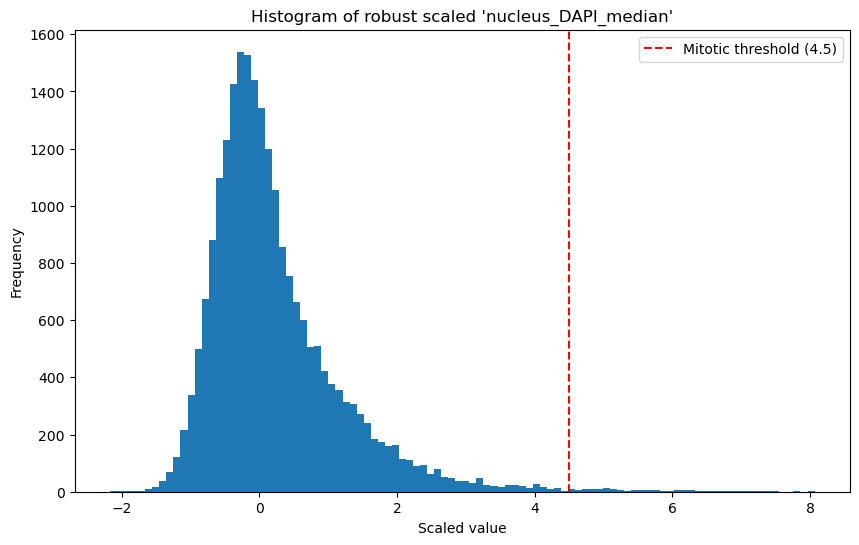

Number of mitotic cells: 149
Total cells: 22,753
Percent mitotic: 0.65%


In [4]:
def plot_mitotic_distribution_hist(cell_data, threshold_var, threshold_value, bins=100):
    """Plot histogram of the robust scaled threshold variable and calculate percent mitotic.
    
    Args:
        cell_data (pd.DataFrame): Dataframe with cell measurements.
        threshold_var (str): Column name to scale and threshold.
        threshold_value (float): Classifier threshold in scaled space.
        bins (int): Number of histogram bins.
    
    Returns:
        float: Percentage of cells classified as mitotic.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.preprocessing import RobustScaler

    # Robust scale the threshold variable column
    values = cell_data[threshold_var].values.reshape(-1, 1)
    scaler = RobustScaler()
    scaled = scaler.fit_transform(values).flatten()

    # Plot histogram with cutoffs
    plt.figure(figsize=(10, 6))
    plt.hist(scaled, bins=bins)
    plt.title(f"Histogram of robust scaled '{threshold_var}'")
    plt.xlabel("Scaled value")
    plt.ylabel("Frequency")
    plt.axvline(x=threshold_value, color="r", linestyle="--", label=f"Mitotic threshold ({threshold_value})")
    plt.legend()
    plt.show()

    # Classify cells and calculate percent mitotic
    mitotic_mask = scaled > threshold_value
    percent_mitotic = (mitotic_mask.sum() / len(scaled)) * 100

    print(f"Number of mitotic cells: {mitotic_mask.sum():,}")
    print(f"Total cells: {len(scaled):,}")
    print(f"Percent mitotic: {percent_mitotic:.2f}%")
    
    return percent_mitotic


MITOTIC_THRESHOLD_VARIABLE = "nucleus_DAPI_median"
MITOTIC_THRESHOLD = 4.5

# clean_cell_data = cell_data.copy()
clean_cell_data = cell_data[cell_data["gene_symbol_0"].notna()].copy()
# clean_cell_data = cell_data.sample(20000)

percent_mitotic = plot_mitotic_distribution_hist(
    clean_cell_data,
    threshold_var=MITOTIC_THRESHOLD_VARIABLE,
    threshold_value=MITOTIC_THRESHOLD,
)

## Define naive classifier

In [5]:
from sklearn.preprocessing import RobustScaler
import numpy as np

class NaiveMitoticClassifier(CellClassifier):
    def __init__(self, threshold_variable="nucleus_DAPI_median", mitotic_threshold=4.7):
        self.threshold_variable = threshold_variable
        self.mitotic_threshold = mitotic_threshold

    def classify_cells(self, cell_data, feature_start_idx):
        # Create a copy to avoid modifying the original
        cell_data = cell_data.copy()
        
        # Extract features and convert to float
        features = cell_data.iloc[:, feature_start_idx:].astype(float)
        
        # Scale features
        scaler = RobustScaler()
        features_scaled = pd.DataFrame(
            scaler.fit_transform(features),
            columns=features.columns,
            index=features.index
        )
        
        # Get the threshold values from scaled features
        threshold_values = features_scaled[self.threshold_variable]
        
        # Classify cells
        classes = np.where(threshold_values > self.mitotic_threshold, "mitotic", "interphase")
        
        # Compute confidence
        confidences = np.zeros(len(cell_data))
        for cl in ["mitotic", "interphase"]:
            idx = np.where(classes == cl)[0]
            if len(idx) > 0:
                sorted_idx = idx[np.argsort(threshold_values.iloc[idx])]
                if cl == "interphase":
                    sorted_idx = sorted_idx[::-1]  # Reverse for interphase
                for rank, i in enumerate(sorted_idx):
                    confidences[i] = (rank + 1) / len(sorted_idx)
        
        return classes, confidences

In [6]:
# Instantiate the classifier
classifier = NaiveMitoticClassifier()

# Predict classes and confidences
classes, confidences = classifier.classify_cells(cell_data, 17)

# Add classes and confidences to the cell data
classified_cell_data = cell_data.copy()
classified_cell_data['class'] = classes
classified_cell_data['confidence'] = confidences

print("Cell class counts:")
print(classified_cell_data["class"].value_counts())

Cell class counts:
class
interphase    49617
mitotic         383
Name: count, dtype: int64


## Create figure to evaluate DAPI cutoff

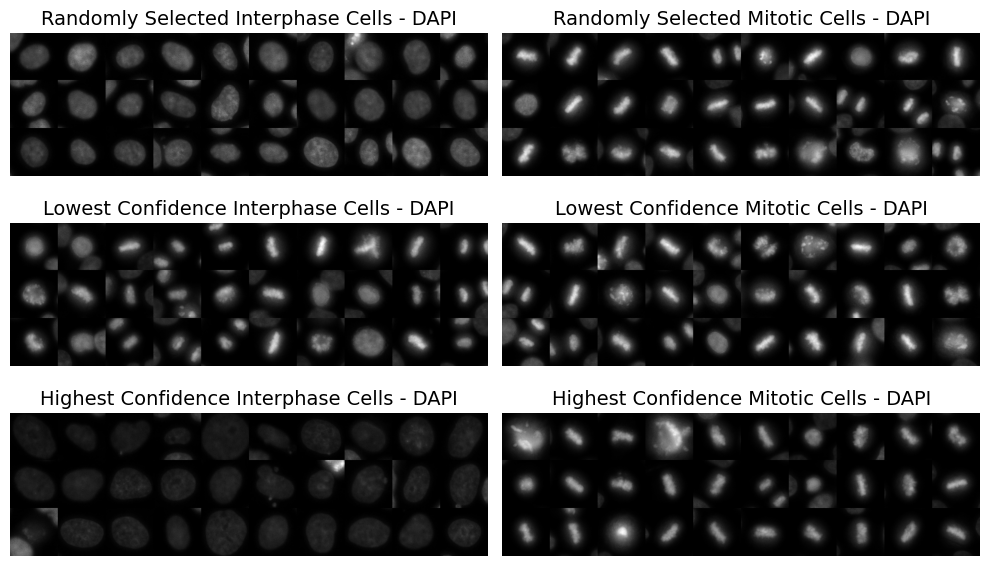

In [7]:
# add filenames to the classified cell data
classified_cell_data = add_filenames(classified_cell_data, ROOT_FP)
# Use final thresholding to split cells
mitotic_df = classified_cell_data[classified_cell_data["class"] == "mitotic"]
interphase_df = classified_cell_data[classified_cell_data["class"] == "interphase"]

# Create figure to evaluate DAPI cutoff

titles = [
    "Randomly Selected Interphase Cells - DAPI",
    "Randomly Selected Mitotic Cells - DAPI",
    "Lowest Confidence Interphase Cells - DAPI",
    "Lowest Confidence Mitotic Cells - DAPI",
    "Highest Confidence Interphase Cells - DAPI",
    "Highest Confidence Mitotic Cells - DAPI",
]

# Get channels from config
CHANNELS = config["phenotype"]["channel_names"]
montages = [
    create_cell_montage(
        cell_data=interphase_df,
        channels=CHANNELS,
        selection_params={
            "method": "random",
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=mitotic_df,
        channels=CHANNELS,
        selection_params={
            "method": "random",
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=interphase_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "confidence",
            "ascending": True,
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=mitotic_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "confidence",
            "ascending": True,
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=interphase_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "confidence",
            "ascending": False,
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=mitotic_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "confidence",
            "ascending": False,
        },
    )["DAPI"],
]

# Initialize figure and subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 6))

# Display each montage
for ax, title, montage in zip(axes.flat, titles, montages):
    ax.imshow(montage, cmap="gray")
    ax.set_title(title, fontsize=14)
    ax.axis("off")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Save classifier

In [8]:
classifier.save("config/naive_mitotic_classifier.pkl")